# Pothole Detection

### Install and Import Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
import pandas as pd
import seaborn as sns
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, Dense, Flatten, Input
from tensorflow.keras.models import Model, load_model, Sequential

### Data

This data comes from the [Cracks and Potholes in Road Images Dataset](https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/tree/master/Dataset). It is licensed under the MIT License, giving us permission to modify and distribute the data for both private and commercial use.

DATA DESCRIPTION

In [2]:
import platform
mysystem = platform.system()
# We need to first download the data here:
file_download_link = "https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset/zipball/master"
# Check for windows

if mysystem != 'Windows':
    !wget -O dataset.zip --no-check-certificate "$file_download_link"
    !unzip dataset.zip

print('Please download the data using the following link:', file_download_link)

Streaming output truncated to the last 5000 lines.
   creating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1092999_DF_251_251BDF0052_00943/
  inflating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1092999_DF_251_251BDF0052_00943/1092999_DF_251_251BDF0052_00943_CRACK.png  
  inflating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1092999_DF_251_251BDF0052_00943/1092999_DF_251_251BDF0052_00943_LANE.png  
  inflating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1092999_DF_251_251BDF0052_00943/1092999_DF_251_251BDF0052_00943_POTHOLE.png  
  inflating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1092999_DF_251_251BDF0052_00943/1092999_DF_251_251BDF0052_00943_RAW.jpg  
   creating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1093000_DF_251_251BDF0052_00945/
  inflating: biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset

### Create Dataset

The first step is to create the dataset with the images, their labels, and the parameters for the pothole bounding boxes. We will use **keras** to load and convert images to numpy arrays, and **cv2** to detect the potholes and label them. We store the dataset as a csv file.

Below is an example of how cv2 creates a bounding box around a pothole using the provided masks.

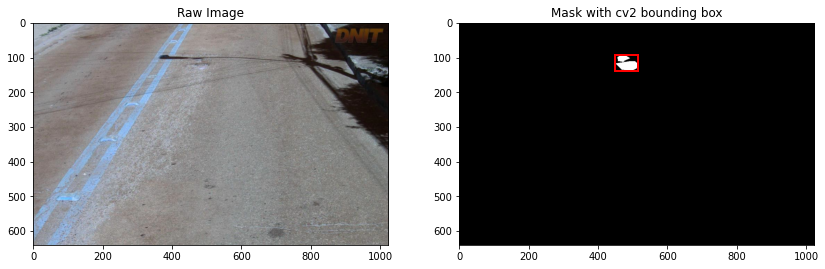

In [7]:
master = '/content/biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset'
path = master + "/820315_ES_259_259ES000000_03060/820315_ES_259_259ES000000_03060_RAW.jpg"
raw_img = cv2.imread(path)
path = master + "/820315_ES_259_259ES000000_03060/820315_ES_259_259ES000000_03060_POTHOLE.png"
mask = cv2.imread(path, 0)
x,y,w,h = cv2.boundingRect(mask)
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Raw Image")
axs[0].imshow(raw_img)
axs[1].set_title("Mask with cv2 bounding box")
axs[1].imshow(mask, cmap= 'gray')
axs[1].add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [8]:
# Create Train/Validation csv
imgs = []
img_paths = []
width = []
height = []
pothole = []
x_center = []
y_center = []
box_w = []
box_h = []
box_w_h = []
xmin = []
xmax = []
ymin = []
ymax = []
box_min_max = []

master = '/content/biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset'
samples = os.listdir(master)
for sample in samples:
    # Path for Raw Image
    img_path = master + "/" + sample + "/" + sample + "_RAW.jpg"
    img_paths.append(img_path)
    # Load image into ram
    # We resize it to (600, 600) and convert to grayscale
    img = keras.preprocessing.image.load_img(img_path, color_mode = 'grayscale', target_size = (600, 600))
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255
    imgs.append(img)
    
    # Image Dimensions
    width.append(600)
    height.append(600)
    
    # Get bounding box of image
    path = master + "/" + sample + "/" + sample + "_POTHOLE.png"
    mask = cv2.imread(path, 0)
    # Convert from 0-255 to 0-1
    mask = (mask > 0).astype(np.uint8)
    mask = cv2.resize(mask,[600,600],cv2.INTER_NEAREST)
    x,y,w,h = cv2.boundingRect(mask)
    x_center.append(x)
    y_center.append(y)
    box_w.append(w)
    box_h.append(h)
    box_w_h.append((x,y,w,h))
    xmin.append(x - int((w/2)))
    ymin.append(y - int((h/2)))
    xmax.append(x + int((w/2)))
    ymax.append(y + int((h/2)))
    box_min_max.append([x - int((w/2)), y - int((h/2)), x + int((w/2)), y + int((h/2))])
    
    # Get label
    if ((x == 0) and (y == 0) and (w == 0) and (h == 0)):
        label = 0
    else:
        label = 1
    pothole.append(label)

# Create Df and csv
df = pd.DataFrame({'img':imgs, 'img_path':img_paths , 'width':width, 'height':height, 'x_center':x_center, 'y_center':y_center, 'box_w':box_w, 'box_h':box_h, 'box_w_h':box_w_h, 'xmin':xmin, 'xmax':xmax, 'ymin':ymin, 'ymax':ymax, 'box_min_max':box_min_max, 'pothole':pothole})
df.to_csv('pothole_data.csv', index=None)

In [10]:
# Load data from csv
potholes = pd.read_csv('/content/pothole_data.csv')
potholes.head()

,img,img_path,width,height,x_center,y_center,box_w,box_h,box_w_h,xmin,xmax,ymin,ymax,box_min_max,pothole
0,[[[0.00784314]\n [0.01960784]\n [0.03529412]...,/content/biankatpas-Cracks-and-Potholes-in-Roa...,600,600,0,0,0,0,"(0, 0, 0, 0)",0,0,0,0,"[0, 0, 0, 0]",0
1,[[[0.47058824]\n [0.8 ]\n [0.8901961 ]...,/content/biankatpas-Cracks-and-Potholes-in-Roa...,600,600,0,0,0,0,"(0, 0, 0, 0)",0,0,0,0,"[0, 0, 0, 0]",0
2,[[[0.49411765]\n [0.5372549 ]\n [0.47843137]...,/content/biankatpas-Cracks-and-Potholes-in-Roa...,600,600,130,501,51,59,"(130, 501, 51, 59)",105,155,472,530,"[105, 472, 155, 530]",1
3,[[[0.25490198]\n [0.24313726]\n [0.23921569]...,/content/biankatpas-Cracks-and-Potholes-in-Roa...,600,600,208,232,52,35,"(208, 232, 52, 35)",182,234,215,249,"[182, 215, 234, 249]",1
4,[[[0.3647059 ]\n [0.47843137]\n [0.36078432]...,/content/biankatpas-Cracks-and-Potholes-in-Roa...,600,600,211,302,293,183,"(211, 302, 293, 183)",65,357,211,393,"[65, 211, 357, 393]",1


### Data Exploration

We are working with a dataset that contains $2235$ samples (images). The target classes are $0$ and $1$, which correspond to the given road containing a pothole ($1$) or not ($0$)

In [ ]:
# Number of Observations
len(potholes)

2235

In [ ]:
# Number of Classes
np.unique(potholes['pothole'])

array([0, 1], dtype=int64)

#### Class distribution

As we can see in the target class distribution, the data is a bit imbalanced. We have $564$ samples with potholes, and $1671$ samples without. This prior could lead to problems, and we will need to adjust how we train our model accordingly.

Images with potholes: 564
Images without potholes: 1671


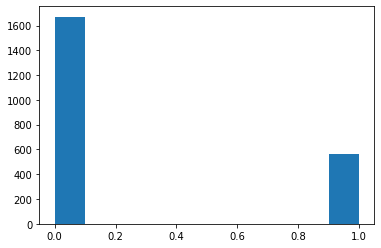

In [ ]:
# Class distribution
plt.hist(potholes['pothole'])
print("Images with potholes: " + str(len(potholes[potholes['pothole']>0])))
print("Images without potholes: " + str(len(potholes[potholes['pothole']<1])))

#### Distribution of bounding box widths and heights

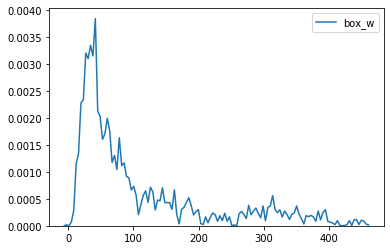

In [ ]:
# Distribution of bounding box widths
sns.kdeplot(potholes['box_w'])

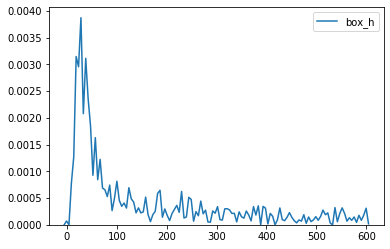

In [ ]:
# Distribution of bouding box heights
sns.kdeplot(potholes['box_h'])

#### Examples of each target class

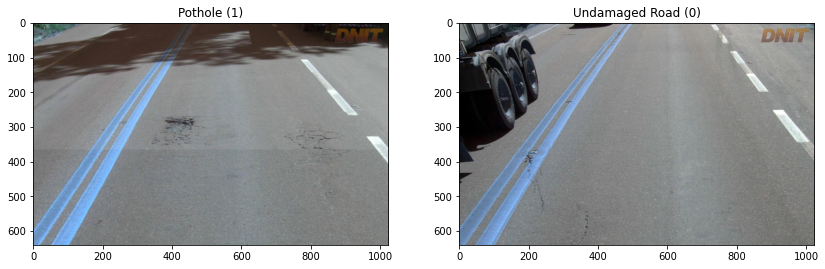

In [12]:
# Plot Examples of Classes
master = '/content/biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset'
path = master + "/765254_ES_259_259ES000000_00370/765254_ES_259_259ES000000_00370_RAW.jpg"
pothole_example = cv2.imread(path)
path = master + "/765442_ES_259_259ES000000_01310/765442_ES_259_259ES000000_01310_RAW.jpg"
undamaged_example = cv2.imread(path)
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Pothole (1)")
axs[0].imshow(pothole_example)
axs[1].set_title("Undamaged Road (0)")
axs[1].imshow(undamaged_example)

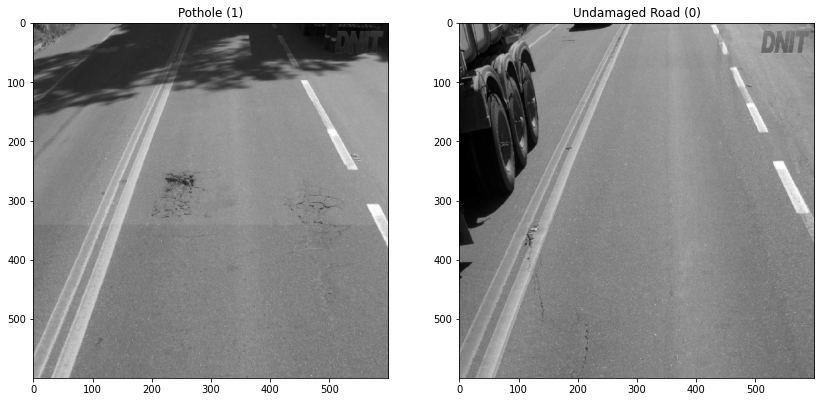

In [13]:
# After rescaling and normalization
master = '/content/biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset'
path = master + "/765254_ES_259_259ES000000_00370/765254_ES_259_259ES000000_00370_RAW.jpg"
img = keras.preprocessing.image.load_img(path, color_mode = 'grayscale', target_size = (600, 600))
img = np.asarray(img)
pothole_example = img/255
path = master + "/765442_ES_259_259ES000000_01310/765442_ES_259_259ES000000_01310_RAW.jpg"
img = keras.preprocessing.image.load_img(path, color_mode = 'grayscale', target_size = (600, 600))
img = np.asarray(img)
undamaged_example = img/255
fig, axs = plt.subplots(1,2, figsize=(14,20))
axs[0].set_title("Pothole (1)")
axs[0].imshow(pothole_example, cmap= 'gray')
axs[1].set_title("Undamaged Road (0)")
axs[1].imshow(undamaged_example, cmap= 'gray')

### Train/Validate split

In [ ]:
# Train/Valitate split
imgs = []
for path in potholes['img_path']:
    p = path
    img = keras.preprocessing.image.load_img(p, color_mode = 'grayscale', target_size = (600, 600))
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255
    imgs.append(img)
X = np.array(imgs)
y = np.array(potholes[["xmin", "ymin", "xmax", "ymax", "pothole"]].values.tolist())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [ ]:
def calculate_iou(target, pred):
    target = tf.cast(target, tf.float32)
    xA = K.maximum(target[:,0], pred[:,0])
    yA = K.maximum(target[:,1], pred[:,1])
    xB = K.minimum(target[:,2], pred[:,2])
    yB = K.minimum(target[:,3], pred[:,3])
    interArea = K.maximum(0.0, xB-xA)*K.maximum(0.0,yB-yA)
    boxAarea = (target[:,2]-target[:,0])*(target[:,3]-target[:,1])
    boxBarea = (pred[:,2]-pred[:,0]) * (pred[:,3]-pred[:,1])
    
    iou = interArea / (boxAarea+boxBarea - interArea)
    return iou

def custom_loss(y_true, y_pred):
    mse = tf.losses.mean_squared_error(y_true, y_pred)
    iou = calculate_iou(y_true , y_pred)
    return mse + (1-iou)

def iou_metric(y_true, y_pred):
    return calculate_iou(y_true, y_pred)

In [ ]:
input_shape = (600, 600, 1)
prediction_units = 5
alpha = 0.2

def block1(filters,X):
    
    x = Conv2D(filters, kernel_size=(3,3), strides=1 )(X)
    x = LeakyReLU(alpha)(x)
    x = Conv2D(filters, (3,3), strides=1)(x)
    x = LeakyReLU(alpha)(x)
    x = MaxPool2D((2,2))(x)
    return x

def block2(units,X):
    
    x = Dense(units)(X)
    x = LeakyReLU(alpha)(x)    
    return x

In [ ]:
def mymodel(input_shape, prediction_units):
    
    model_input = Input(shape=input_shape)
    x= block1(16, model_input)
    x= block1(32,x)    
    x = Flatten()(x)
    x = block2(62,x)
    model_outputs = Dense(prediction_units)(x)
    
    model = Model(inputs=[model_input], outputs=[model_outputs])
    
    model.compile( tf.keras.optimizers.Adam(0.0001),
                 loss=custom_loss,
                 metrics=[iou_metric])
    
    return model

In [ ]:
model = mymodel(input_shape, prediction_units)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=2
)

Epoch 1/40
894/894 [==============================] - 34s 37ms/step - loss: 15856.7930 - iou_metric: 1.2251e-04 - val_loss: 17456.9629 - val_iou_metric: 7.4248e-05
Epoch 2/40
894/894 [==============================] - 32s 36ms/step - loss: 15502.6934 - iou_metric: 2.8690e-04 - val_loss: 16719.6172 - val_iou_metric: 9.1251e-05
Epoch 3/40
894/894 [==============================] - 32s 36ms/step - loss: 14270.8252 - iou_metric: 0.0022 - val_loss: 15786.4756 - val_iou_metric: 0.0036
Epoch 4/40
894/894 [==============================] - 32s 36ms/step - loss: 13294.4473 - iou_metric: 0.0058 - val_loss: 15933.2783 - val_iou_metric: 0.0060
Epoch 5/40
894/894 [==============================] - 32s 36ms/step - loss: 12644.3291 - iou_metric: 0.0088 - val_loss: 15653.7832 - val_iou_metric: 0.0027
Epoch 6/40
894/894 [==============================] - 32s 36ms/step - loss: 12257.4014 - iou_metric: 0.0098 - val_loss: 14794.7432 - val_iou_metric: 0.0087
Epoch 7/40
894/894 [============================

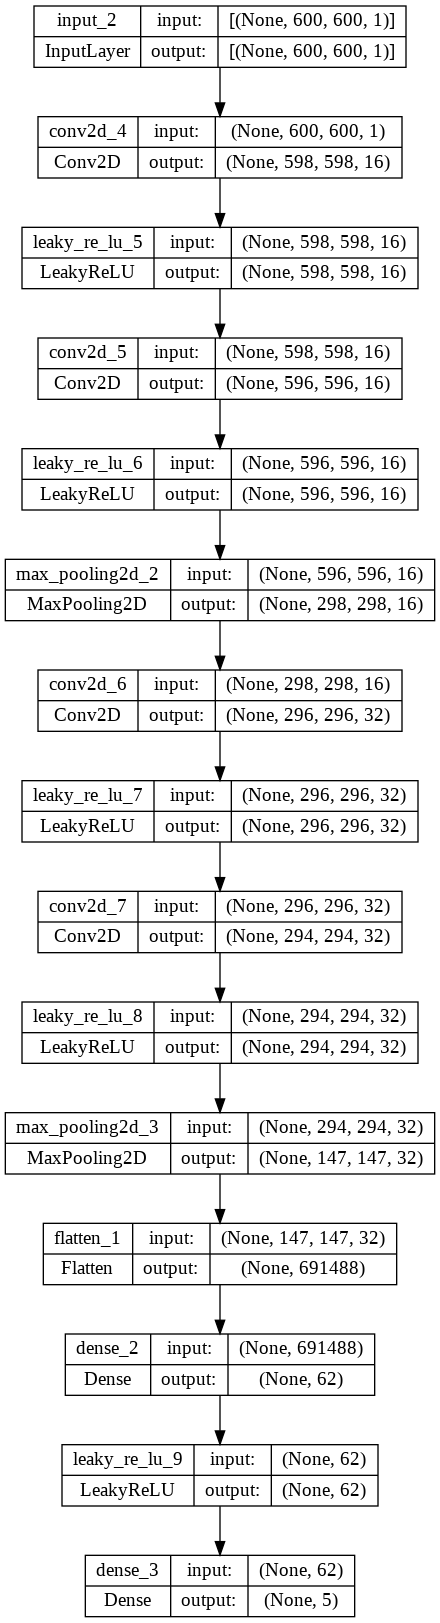

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

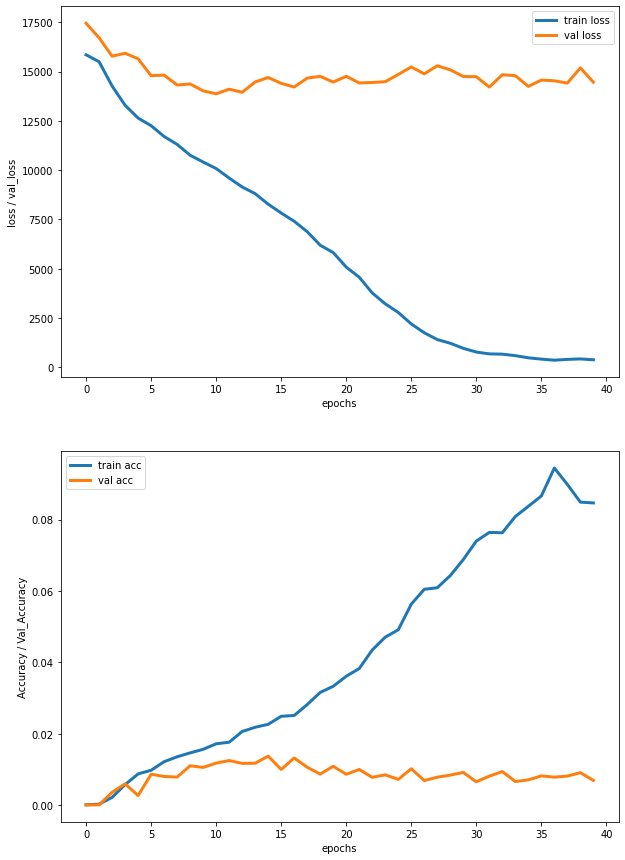

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['iou_metric']
val_acc = history.history['val_iou_metric']


plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
plt.plot(loss , linewidth=3 ,label='train loss')
plt.plot(val_loss , linewidth=3, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss / val_loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(acc , linewidth=3 ,label='train acc')
plt.plot(val_acc , linewidth=3, label='val acc')
plt.xlabel('epochs')
plt.ylabel('Accuracy / Val_Accuracy')
plt.legend()

In [ ]:
model.save('simplemodel')

1/1 [==============================] - 0s 18ms/step


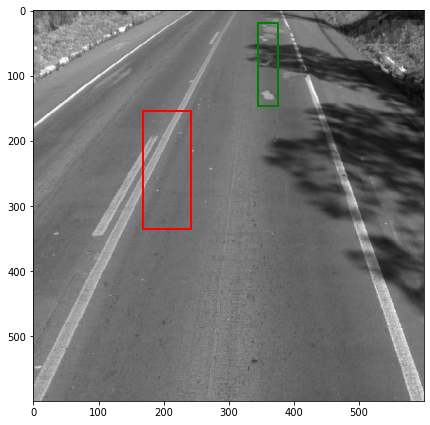

In [ ]:
# Example prediction with simple model
fig, ax = plt.subplots(1,1, figsize=(7,10))
ax.imshow(np.reshape(X_test[1], (600,600)), cmap='gray', vmin=0, vmax=1)
xmin,ymin,xmax,ymax = (y_test[1][0], y_test[1][1], y_test[1][2], y_test[1][3])
w = (xmax-xmin)
h = (ymax-ymin)
x = round(xmin + (w/2))
y = round(ymin + (h/2))
ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='green', lw=2))
img = tf.cast(np.expand_dims(X_test[1], axis=0), tf.float32)
pred = model.predict(img)
xmin,ymin,xmax,ymax = (pred[0][0], pred[0][1], pred[0][2], pred[0][3])
w = (xmax-xmin)
h = (ymax-ymin)
x = round(xmin + (w/2))
y = round(ymin + (h/2))
ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [ ]:
# Models:
# Model that simply predicts bounding boxes
# Model with classification branch and bounding box branch
# Model with clissification feeding into bounding box